# __1. Thư viện__

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd "/content/drive/MyDrive/Colab Notebooks/Code/NopThay"

In [3]:
# !pip install keras-tuner
# !pip install import-ipynb
# !pip install underthesea
# !pip install advertools
# !pip install emoji
# !pip install regex

In [1]:
import pandas as pd
import numpy as np
import torch
import ast

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split

import string
import advertools as adv
import emoji
import regex as re
from underthesea import word_tokenize, pos_tag

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import import_ipynb
import MLTunning as MLT

# __2. Vectorize - PreTrainModel__

In [3]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")
model = AutoModel.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

def vectorize_comment(comment):
    inputs = tokenizer(comment, return_tensors="pt", padding=True, truncation=True)
    # Lấy hidden states
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state
    sentence_embedding = hidden_states.mean(dim=1)
    return sentence_embedding.squeeze(0).numpy()

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at wonrax/phobert-base-vietnamese-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def convert_embeddings_to_tensor(df):
    embeddings = df['embedding'].apply(lambda x: tf.convert_to_tensor(np.array(x).reshape(1, -1), dtype=tf.float32))

    embeddings_tensor = np.array(embeddings.tolist())

    return embeddings_tensor

# __3. Phân tích đánh giá câu dài__

### ___3.1. Đọc dữ liệu và xây dựng model___

In [5]:
file_path = r'preprocessed_data.xlsx'
df = pd.read_excel(file_path)
df.head()

,content_comments,comment_eng,sentiment,word_tokenize
0,thay đổi coment tăng size hãy làm như bạn muố...,Change the cmt to increase 1 size. Please do a...,0,thay_đổi coment tăng size hãy làm như bạn muốn...
1,quần dày mỗi lần size nhỏ nhắn tin cửa hàng đổ...,"thick pants\nEvery time the size is small, mes...",0,quần dày mỗi lần size nhỏ_nhắn tin cửa_hàng đổ...
2,đã nhận được đóng gói màu đúng mẫu đúng sau sẽ...,Received the goods...shop packaged quickly...r...,1,đã nhận được đóng_gói màu đúng mẫu đúng sau sẽ...
3,đã nhận được đóng gói sizesẽ khả năng quay lại...,Received the goods...shop packaged quickly...r...,1,đã nhận được đóng_gói sizesẽ khả_năng quay lại...
4,hình ảnh nhận xu và quan đơn giản thôi mua nhi...,The picture of receipt of coin and quan is sim...,0,hình_ảnh nhận xu và quan đơn_giản thôi mua nhi...


In [9]:
# Đảm bảo rằng tất cả các giá trị trong 'word_tokenize' là chuỗi hợp lệ
df['word_tokenize'] = df['word_tokenize'].apply(lambda x: str(x) if isinstance(x, (int, float)) else x)

# Áp dụng hàm vectorize_comment
df['embedding'] = df['word_tokenize'].apply(vectorize_comment)

In [10]:
X_train_comments = df['embedding']
y_train = df['sentiment']

X_train_comments = convert_embeddings_to_tensor(df)

In [11]:
X_train_comments, val_x_comments, y_train, val_y = train_test_split(X_train_comments, y_train, test_size=0.2, random_state=42)

In [12]:
X_train_reshaped = X_train_comments.reshape(X_train_comments.shape[0], -1)
val_x_reshaped = val_x_comments.reshape(val_x_comments.shape[0], -1)

### ___3.2. ML - Logistic regression___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.001}
Best score (Logistic regression): 0.9483226318447443
Best Logistic regression Accuracy: 0.9375
Best Logistic regression Precision: 0.9279279279279279
Best Logistic regression Recall: 0.9537037037037037
Best Logistic regression AUC: 0.9381907680876752

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        97
           1       0.95      0.93      0.94       111

    accuracy                           0.94       208
   macro avg       0.94      0.94      0.94       208
weighted avg       0.94      0.94      0.94       208

ROC_AUC_SCORE is  0.9381907680876752


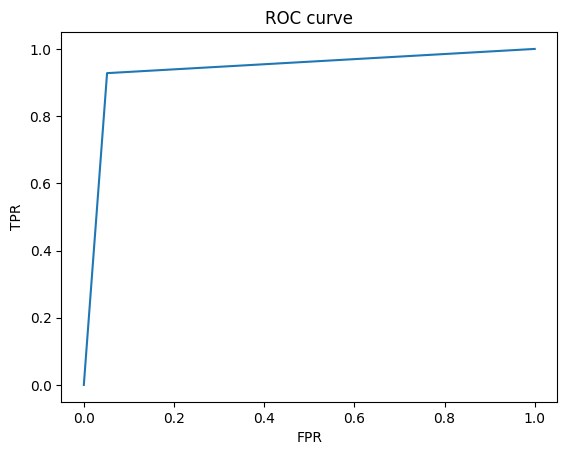

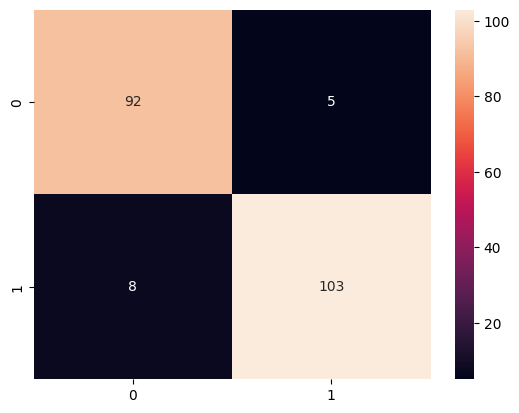

In [13]:
logreg_results = MLT.tune_logistic_regression(X_train_reshaped, y_train, val_x_reshaped, val_y)

In [14]:
best_logreg_model = logreg_results[0]

### ___3.3. ML-Random Forest___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 232}
Best score (RandomForestClassifier): 0.9495274511218526
Best Random Forest Accuracy: 0.9375
Best Random Forest Precision: 0.9279279279279279
Best Random Forest Recall: 0.9537037037037037
Best Random Forest AUC: 0.9381907680876752
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        97
           1       0.95      0.93      0.94       111

    accuracy                           0.94       208
   macro avg       0.94      0.94      0.94       208
weighted avg       0.94      0.94      0.94       208

ROC_AUC_SCORE is  0.9381907680876752


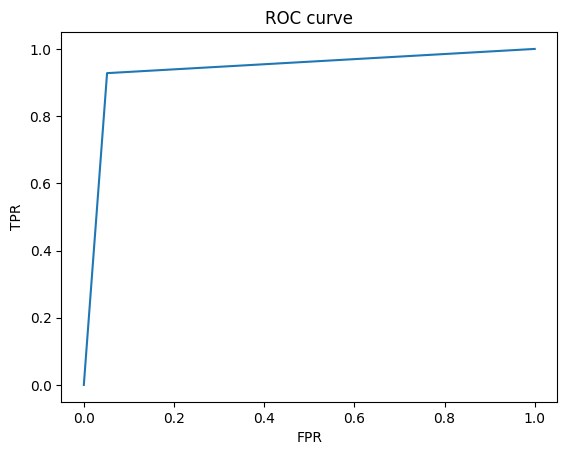

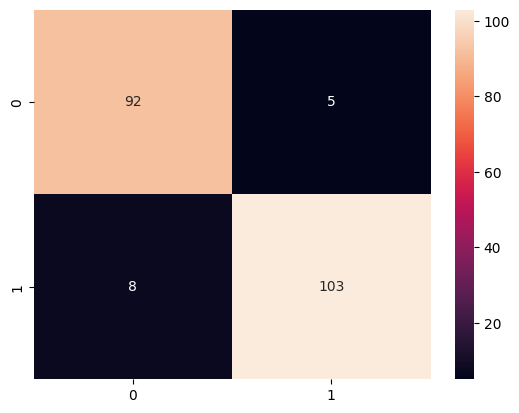

In [15]:
rf_results = MLT.tune_random_forest(X_train_reshaped, y_train, val_x_reshaped, val_y)

In [16]:
best_rf_model = rf_results[0]

### ___3.4. ML-Naive Bayes___

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
val_x_scaled = scaler.transform(val_x_reshaped)

Best hyperparameters (MultinomialNB): {'alpha': 8.904822277414155}
Best score (MultinomialNB): 0.9411225741288508
Best Navie Bayes Accuracy: 0.9326923076923077
Best Naive Bayes Precision: 0.918918918918919
Best Navie Bayes Recall: 0.9532710280373832
Best Naive Bayes AUC: 0.9336862635831708
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        97
           1       0.95      0.92      0.94       111

    accuracy                           0.93       208
   macro avg       0.93      0.93      0.93       208
weighted avg       0.93      0.93      0.93       208

ROC_AUC_SCORE is  0.9336862635831708


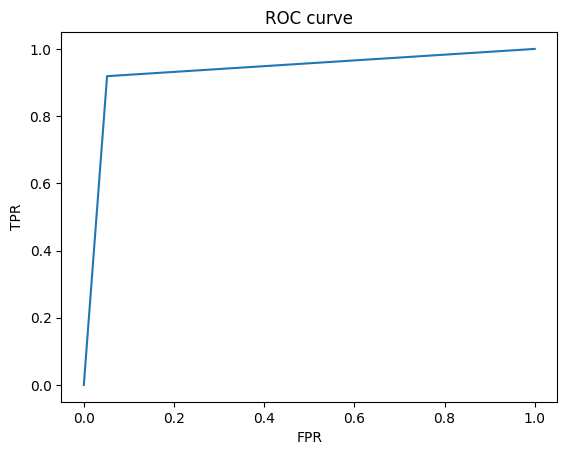

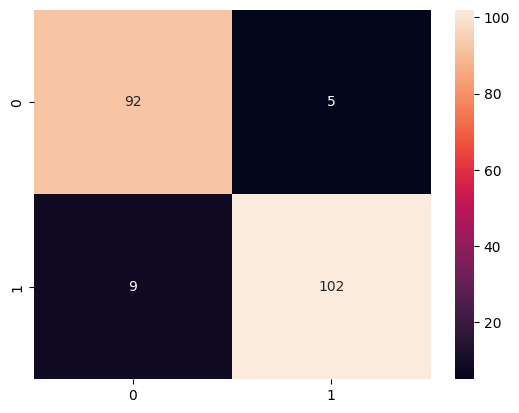

In [18]:
nb_results = MLT.tune_multinomial_nb(X_train_scaled, y_train, val_x_scaled, val_y)

In [19]:
best_nb_results = nb_results[0]

### ___3.5. DL-LSTM___

In [20]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()

    # Đầu vào đã có sẵn embedding với shape (batch_size, 1, 768)
    model.add(Input(shape=(1, 768)))  # Đầu vào của dữ liệu embedding có shape (1, 768)

    for _ in range(hp.Int('num_lstm_layers', 1, 3)):  # Từ 1 đến 3 lớp LSTM
        model.add(LSTM(hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))
        model.add(Dropout(0.5))

    model.add(GlobalAveragePooling1D())  # Tổng hợp thông tin từ các bước
    model.add(Dense(1, activation='sigmoid'))  # Phân loại nhị phân (0 hoặc 1)

    model.compile(
        loss='binary_crossentropy',  # Sử dụng loss nhị phân cho bài toán phân loại 2 lớp
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        metrics=['accuracy']
    )

    return model

# Đường dẫn và tên dự án
base_dir = r'sentiment_NKKK'
project_name = 'sentiment_NLP'
directory = os.path.join(base_dir, project_name)

# Kiểm tra và tạo thư mục nếu chưa có
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

# Tuner tìm kiếm siêu tham số
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Tối ưu hóa theo độ chính xác trên tập validation
    max_trials=2,  # Số lần thử
    executions_per_trial=1,  # Mỗi thử nghiệm sẽ chạy 1 lần
    directory=base_dir,
    project_name=project_name
)

# Tiến hành tìm kiếm siêu tham số
tuner.search(X_train_comments, y_train, epochs=5, validation_data=(val_x_comments, val_y))

# Lấy các siêu tham số tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Trial 2 Complete [00h 00m 07s]
val_accuracy: 0.9375

Best val_accuracy So Far: 0.9375
Total elapsed time: 00h 00m 33s
Best hyperparameters found:
LSTM units: 32
Number of LSTM layers: 3
Learning rate: 0.004509469335380268


In [ ]:
# Lấy mô hình tốt nhất từ tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Lưu mô hình tốt nhất vào file
best_model_path = os.path.join(directory, 'PhoBERT_LSTM_best_model.h5')
best_model.save(best_model_path)
print(f"Best model saved to {best_model_path}")

# __4. Phân tích đánh giá câu ngắn__

### ___4.1. Đọc dữ liệu và xây dựng mô hình___

In [21]:
file_path1 = r'preprocessed_data1.xlsx'
df1 = pd.read_excel(file_path1)
print(df1.head())

   Unnamed: 0                                            comment  \
0         3.0                                           thun dày   
1         4.0                                    túi có khóa kéo   
2         NaN  mỗi lần size nhỏ nhắn cửa hàng đổi size to hơn...   
3         8.0                                           quần dày   
4         9.0                                  đã nhận được hàng   

   sentiment_manual                                      word_tokenize  
0                 1                                           thun dày  
1                 1                                    túi có khóa kéo  
2                 0  mỗi lần size nhỏ_nhắn cửa_hàng đổi size to hơn...  
3                 1                                           quần dày  
4                 1                                  đã nhận được hàng  


In [22]:
df1['word_tokenize'] = df1['word_tokenize'].astype(str)

In [23]:
df1['embedding'] = df1['word_tokenize'].apply(vectorize_comment)

In [30]:
X_train_comments = df1['embedding']
y_train = df1['sentiment_manual']

X_train_comments = convert_embeddings_to_tensor(df1)

In [31]:
X_train_reshaped = X_train_comments.reshape(X_train_comments.shape[0], -1)
val_x_reshaped = val_x_comments.reshape(val_x_comments.shape[0], -1)

### ___4.2. ML-Logistic regreesion___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best hyperparameters (Logistic regression): {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
Best score (Logistic regression): 0.9191514437242192
Best Logistic regression Accuracy: 0.9567307692307693
Best Logistic regression Precision: 0.972972972972973
Best Logistic regression Recall: 0.9473684210526315
Best Logistic regression AUC: 0.9555586514349401

Classification Report:  LogisticRegression
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        97
           1       0.95      0.97      0.96       111

    accuracy                           0.96       208
   macro avg       0.96      0.96      0.96       208
weighted avg       0.96      0.96      0.96       208

ROC_AUC_SCORE is  0.9555586514349401


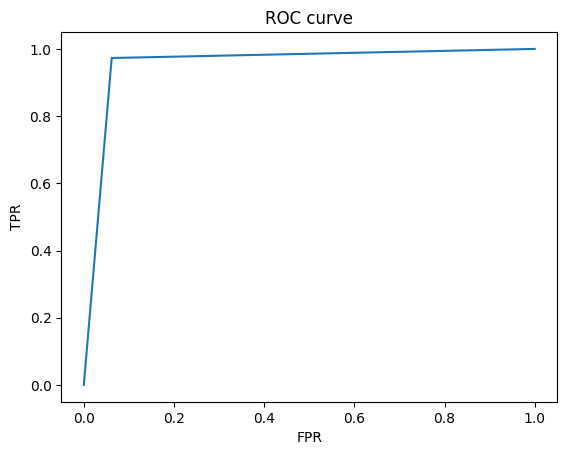

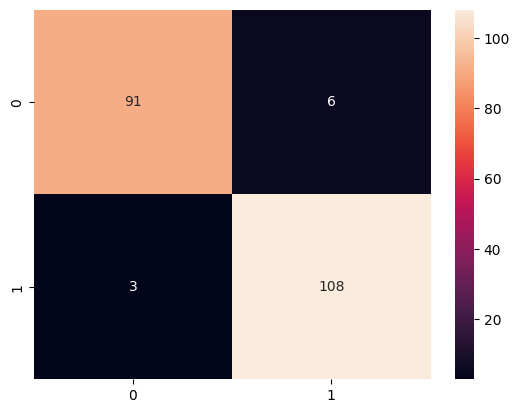

In [32]:
logreg_results = MLT.tune_logistic_regression(X_train_reshaped, y_train, val_x_reshaped, val_y)

In [33]:
best_logreg_model_split = logreg_results[0]

### ___4.3. ML-RandomForest___

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\base.py", line 666, in _validat

Best hyperparameters (RandomForestClassifier): {'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 192}
Best score (RandomForestClassifier): 0.9228049499116088
Best Random Forest Accuracy: 0.9471153846153846
Best Random Forest Precision: 0.963963963963964
Best Random Forest Recall: 0.9385964912280702
Best Random Forest AUC: 0.945899507755178
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        97
           1       0.94      0.96      0.95       111

    accuracy                           0.95       208
   macro avg       0.95      0.95      0.95       208
weighted avg       0.95      0.95      0.95       208

ROC_AUC_SCORE is  0.945899507755178


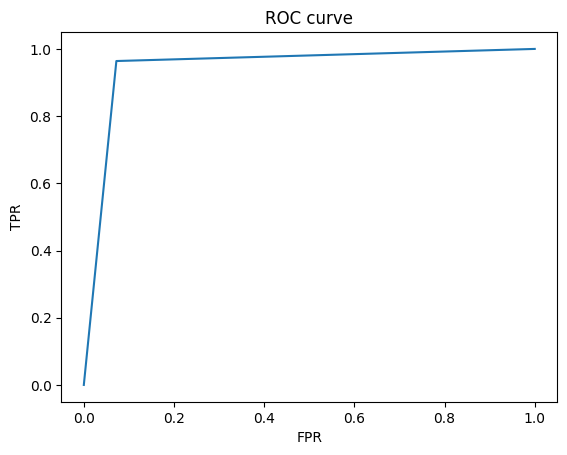

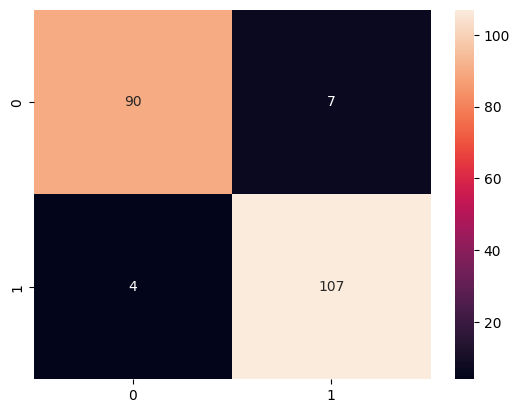

In [34]:
rf_results = MLT.tune_random_forest(X_train_reshaped, y_train, val_x_reshaped, val_y)

In [35]:
best_rf_model_split = rf_results[0]

### ___4.4. ML-Naive Bayes___

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
val_x_scaled = scaler.transform(val_x_reshaped)

Best hyperparameters (MultinomialNB): {'alpha': 6.3310949480747665}
Best score (MultinomialNB): 0.9000589275191514
Best Navie Bayes Accuracy: 0.9375
Best Naive Bayes Precision: 0.9369369369369369
Best Navie Bayes Recall: 0.9454545454545454
Best Naive Bayes AUC: 0.9375406334169221
Classification Report:  MultinomialNB
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        97
           1       0.95      0.94      0.94       111

    accuracy                           0.94       208
   macro avg       0.94      0.94      0.94       208
weighted avg       0.94      0.94      0.94       208

ROC_AUC_SCORE is  0.9375406334169221


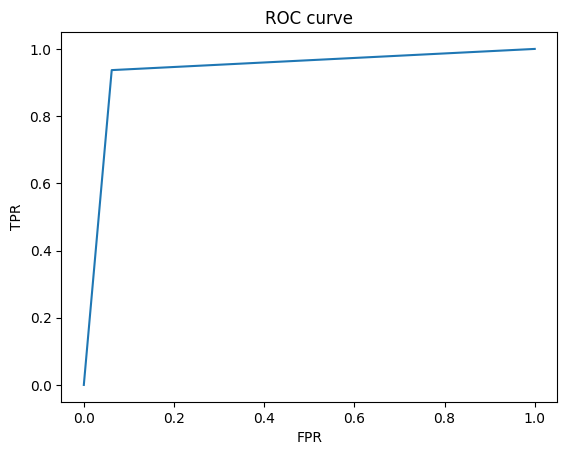

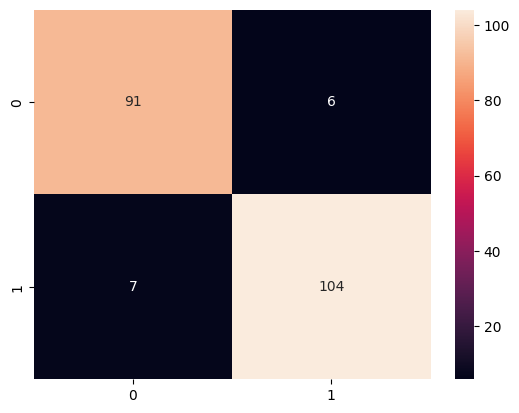

In [37]:
nb_results = MLT.tune_multinomial_nb(X_train_scaled, y_train, val_x_scaled, val_y)

In [38]:
best_nb_results_split = nb_results[0]

### ___4.5. DL-LSTM___

In [39]:
# Đường dẫn và tên dự án
base_dir = r'sentiment_NKK'
project_name = 'Sentiment_NLP_Split'
directory = os.path.join(base_dir, project_name)

# Kiểm tra và tạo thư mục nếu chưa có
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Created directory: {directory}")
else:
    print(f"Directory already exists: {directory}")

# Tuner tìm kiếm siêu tham số
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Tối ưu hóa theo độ chính xác trên tập validation
    max_trials=2,  # Số lần thử
    executions_per_trial=1,  # Mỗi thử nghiệm sẽ chạy 1 lần
    directory=base_dir,
    project_name=project_name
)

# Tiến hành tìm kiếm siêu tham số
tuner.search(X_train_comments, y_train, epochs=5, validation_data=(val_x_comments, val_y))

# Lấy các siêu tham số tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Number of LSTM layers: {best_hps.get('num_lstm_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Trial 2 Complete [00h 01m 22s]
val_accuracy: 0.9375

Best val_accuracy So Far: 0.9375
Total elapsed time: 00h 02m 17s
Best hyperparameters found:
LSTM units: 32
Number of LSTM layers: 1
Learning rate: 0.005243440688531572
